# Welcome to M-LSD demo

In this demo, you can simply run line segment detection and box detection with our M-LSD models.

Thanks to [gradio](https://gradio.app/), this demo is interactive!

- For the line segment detection demo: Launch line segment detection with M-LSD

- For the box detection demo: Launch box detection with M-LSD

## Preliminaries
This section contains the initial setup.
Please, run it first.

### Clone M-LSD repository

### Install gradio

### Initialize tflite model and functions

In [2]:
import os
import subprocess
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf
from utils import pred_lines, pred_squares
#import gradio as gr
from urllib.request import urlretrieve


# Load MLSD 512 Large FP32 tflite
model_name = 'D:/mlsd/tflite_models/M-LSD_512_tiny_fp32.tflite'
interpreter = tf.lite.Interpreter(model_path=model_name)

interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## Launch line segment detection with M-LSD

In [3]:
def wrapper_for_LSD(img_input, score_thr, dist_thr):
  lines = pred_lines(img_input, interpreter, input_details, output_details, input_shape=[512, 512], score_thr=score_thr, dist_thr=dist_thr)
  img_output = img_input.copy()

  # draw lines
  for line in lines:
    x_start, y_start, x_end, y_end = [int(val) for val in line]
    cv2.line(img_output, (x_start, y_start), (x_end, y_end), [0,255,255], 2)
  
  return img_output,lines



In [6]:
import sys
import glob
import cv2
import numpy as np
import natsort
import matplotlib.pyplot as plt
import time
imgfiles=[]

for file in sorted(glob.glob("D:/frameimages/frame*.jpg")):
    imgfiles.append(file)

imgfiles=natsort.natsorted(imgfiles)

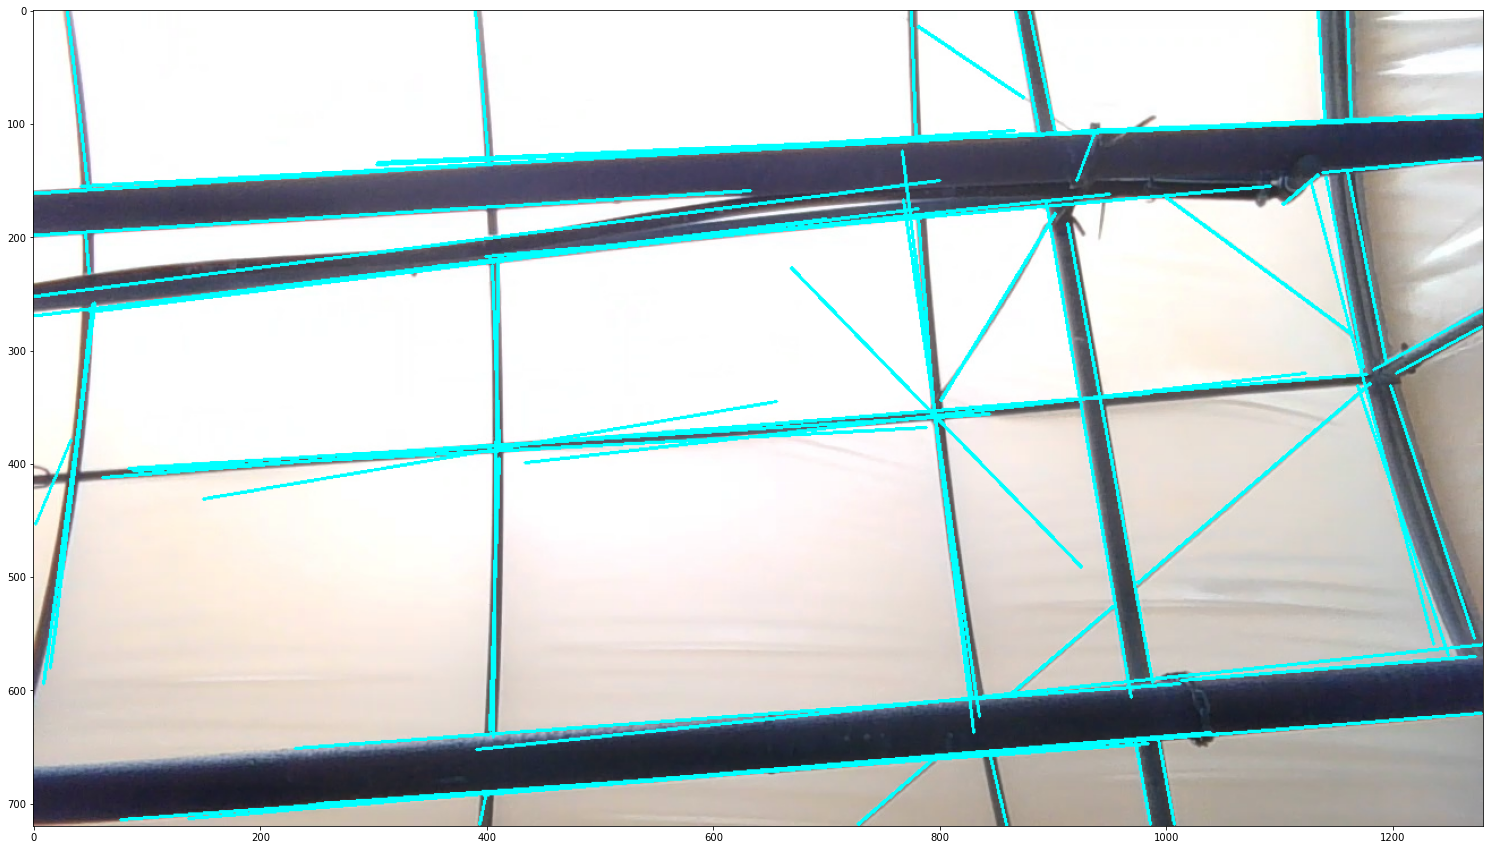

In [7]:
image = cv2.imread(imgfiles[3000])
img_out,lines=wrapper_for_LSD(image,0.2,10)
plt.figure(figsize=(30,15)) 
plt.imshow(img_out)
plt.show()

In [5]:
lines.astype(int)

array([[1090,   -1, 1147,  314],
       [1057,    0, 1116,  316],
       [  -2,    6,   57,    0],
       [ 967,   -2,  988,  326],
       [ 980,   -2,  997,  325],
       [   7,  465,   23,  712],
       [ 407,   -1,  465,  353],
       [ 996,  394, 1028,  653],
       [1025,  653, 1110,  720],
       [ 999,  295, 1045,  322],
       [ 474,  435,  500,  713],
       [ 999,  396, 1033,  723],
       [1126,  381, 1173,  719],
       [   4,  461,  451,  431],
       [ 488,    2,  991,  290],
       [1025,  666, 1032,  717],
       [1140,  476, 1171,  716],
       [1161,  381, 1210,  718],
       [   4,  397,  451,  363],
       [1172,  461, 1210,  716],
       [1212,  453, 1253,  719],
       [1043,  665, 1158,  663],
       [ 486,  358, 1179,  314],
       [ 495,  431, 1148,  383],
       [ 464,  695, 1166,  652],
       [ 285,  710, 1026,  660],
       [ 287,  698, 1025,  651],
       [1161,  389, 1204,  410],
       [1205,  665, 1209,  719],
       [1201,  382, 1257,  717],
       [12

## Best Line Tracking with M-LSD

In [9]:
import os
#import rospy
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
from common import draw_str


class BestLineDetection(object):
    
    def __init__(self, angle=90,tolerance=5,scale=100,score_thr=0.2,dist_thr=10):
        ## A flag that indicates if the output image shall be drawn 
        self.draw_img = True
        self.scale_percent = scale  # rescale the resolution if needed
        self.angle = angle
        self.range = tolerance      # angle error tolerance
        self.angle_weight=0.5
        self.width_weight=3
        self.length_weight=0.1
                                  # postion weight
        self.score_thr=score_thr
        self.dist_thr=dist_thr
        self.minWidth= 1
        self.minLength = 50
     
    def setAngle(self,new_angle):
        self.angle=new_angle
    
    def setTolerance (self, new_tolerance):
        self.range=new_tolerance
        
    # pre-process the input image by resizing, grayscaling, lsding and caluclating the line segments' angles, lengths and credits  
    def processImage(self, input_image):
        
        # Resized Image
        #resized_img = self.resize_img(input_image, self.scale_percent)
        # Convert to grayscale
        #img_gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

        # LSD
        segments = self.LSD(input_image)
        if segments.shape[0]==0:
            lines_info=segments.reshape(0,8)
        else:
            angles = line_angle(segments)
            lengths = line_length(segments)
            lines_info = np.append(segments, angles, axis=1)
            lines_info = np.append(lines_info, lengths, axis=1)

            credits = line_credit(lines_info,self.angle_weight,self.width_weight,self.length_weight)
            lines_info = np.append(lines_info, credits, axis=1)
      
        return lines_info
    

    def resize_img(self, img, scale_percent):
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        resized_img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

        return resized_img

    
    def LSD(self, input_image):
        # [point1.x, point1.y, point2.x, point2.y, width]
        output_img,segments=wrapper_for_LSD(input_image, self.score_thr, self.dist_thr)
        widths=np.ones((segments.shape[0],1))
        segments=np.append(segments,widths,axis=1)
        return segments
    

    def bestline_picker(self, input_image):
        lines_info=self.processImage(input_image)
        # [point1.x, point1.y, point2.x, point2.y, width, angle, length, credit]
        copy=np.copy(input_image)
        bestline = pick_bestline(self.angle, lines_info,self.range, self.minWidth, self.minLength)
        if bestline[6]!=0:
            
            output_image = draw_bestline(copy, bestline)
            #draw_str(output_image, (20, 20), 'Angle_drift: %d' % (bestline[5] - self.angle) + ' Length: %d' % bestline[6])
            #draw_str(output_image, (20, 40), 'delta_x: %d' % (bestline[0] - bestline[2]))
            #print("Deata x =", bestline[0] - bestline[2])  
        else:
            output_image = input_image
        return bestline, output_image, lines_info


# Caculation methods of line lengths, angles and credits
def line_angle(segments):
    rows = segments.shape[0]
    x1, y1, x2, y2 = segments[:,0],segments[:,1],segments[:,2],segments[:,3]
    angles = np.degrees(np.arctan2(y1 - y2, x2 - x1))  # y axis reverses in pixel coordinate, so y1-y2
    np.where(angles>=0,angles,angles+180)
    return angles.reshape(rows, -1)



def line_length(segments):
    rows = segments.shape[0]
    point1 = segments[:,0:2]
    point2 = segments[:,2:4]
    lengths=np.linalg.norm(point2-point1,axis=-1) # apply L2 norm to each row
    return lengths.reshape(rows, -1)


def line_credit(lines_info,angle_weight, width_weight, length_weight):
    rows = lines_info.shape[0]
    credits = angle_weight*lines_info[:,5]+width_weight*lines_info[:,4]+length_weight*lines_info[:,6]
    return credits.reshape(rows,-1)


def draw_bestline(img, lines_info):
    coordinates = lines_info[0:4].reshape([2, 2]).astype(int)
    best_img = cv2.line(img, (coordinates[0][0], coordinates[0][1]), (coordinates[1][0], coordinates[1][1]),
                        (255, 0, 0), 3)
    return best_img


def pick_bestline(theta, lines_info, tolerance, minWidth, minLength):  # pick the line with the most credits within valid range
    # valid range: theta-range<=angle<= theta+range, width>=minWidth, length>=minLength
    closelines=lines_info[(lines_info[:, 5] >= (theta - tolerance)) & (lines_info[:, 5] <= (theta + tolerance)) 
                          & (lines_info[:,4]>=minWidth) 
                          & (lines_info[:, 6]>=minLength)] 
    if closelines.size == 0: # if there is no line within the range
        #flag = False
        return np.zeros(8)
    else:
        #flag = True
        index_close=np.argmax(closelines[:, 7])
        index=np.where(np.all(lines_info==closelines[index_close],axis=1))               
        return lines_info[index[0][0]]
    
    
def pick_sameline(prev_bestline, curr_lines):
    dists=[]
    rows=curr_lines.shape[0]
    #print(prev_bestline[:2].astype(int))
    for i in curr_lines:
        distance= min((np.linalg.norm(i[:2] - prev_bestline[:2])),(np.linalg.norm(i[2:4] - prev_bestline[:2])))
        #print(distance)
        dists.append(distance)
    dists=np.array(dists).reshape(rows, -1)
    
    curr_lines=np.append(curr_lines,dists,axis=1)
    closelines=curr_lines[curr_lines[:,8]<20]
    #print(closelines.astype(int))
    if closelines.size==0:
        print("No same line!")
        return np.zeros(8),closelines, True
    else:
        index_nearest=np.abs(closelines[:,5]-prev_bestline[5]).argmin()
        index=np.where(np.all(curr_lines==closelines[index_nearest],axis=1))
        return curr_lines[index[0][0]],closelines, False
    
def drift_detection (bestline_1, bestline_2, image): #less priority
    ratio = 0.01
    x_total = image.shape[1]
    if (bestline_1[1] > bestline_1[3]):
        x_1 = bestline_1[0]
    else:
        x_1 = bestline_1[2]
    if (bestline_2[1] > bestline_2[3]):
        x_2 = bestline_2[0]
    else:
        x_2 = bestline_2[2]
    lateral_drift = x_1 - x_2
#     if (math.dist(bestline_1[:2],bestline_2[:2])<math.dist(bestline_1[:2],bestline_2[2:4])):
#         lateral_drift= bestline_1[0]-bestline_2[0]
#     else:
#         lateral_drift= bestline_1[0]-bestline_2[2]
    #ignore the when picking new_lines
    if abs(lateral_drift) <= x_total * ratio:
        return lateral_drift
    else:
        return 0

(720, 1280, 3)
time elapsed =  0.7338106632232666
(720, 1280, 3)


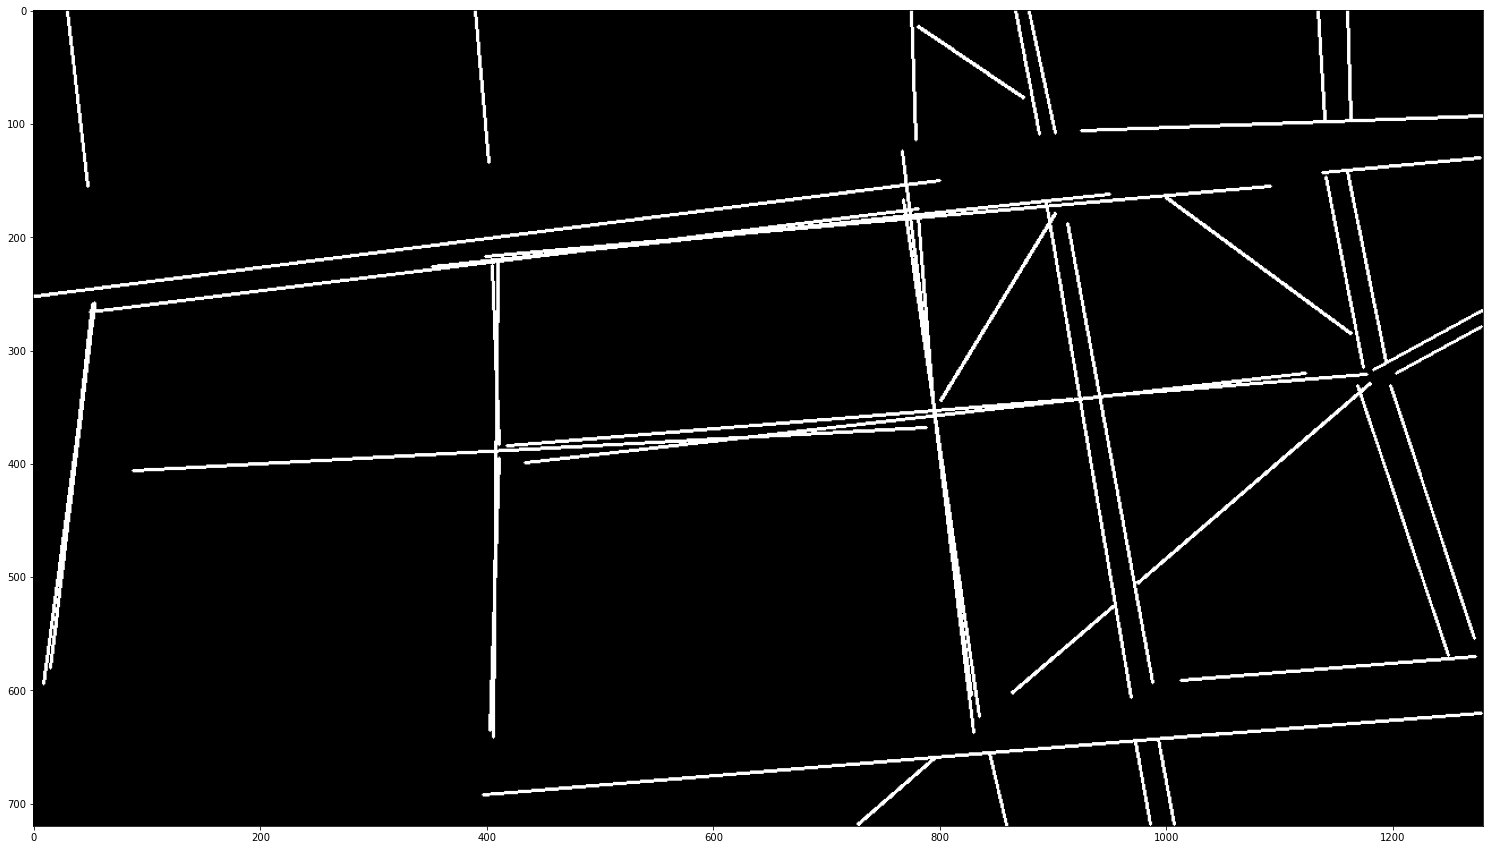

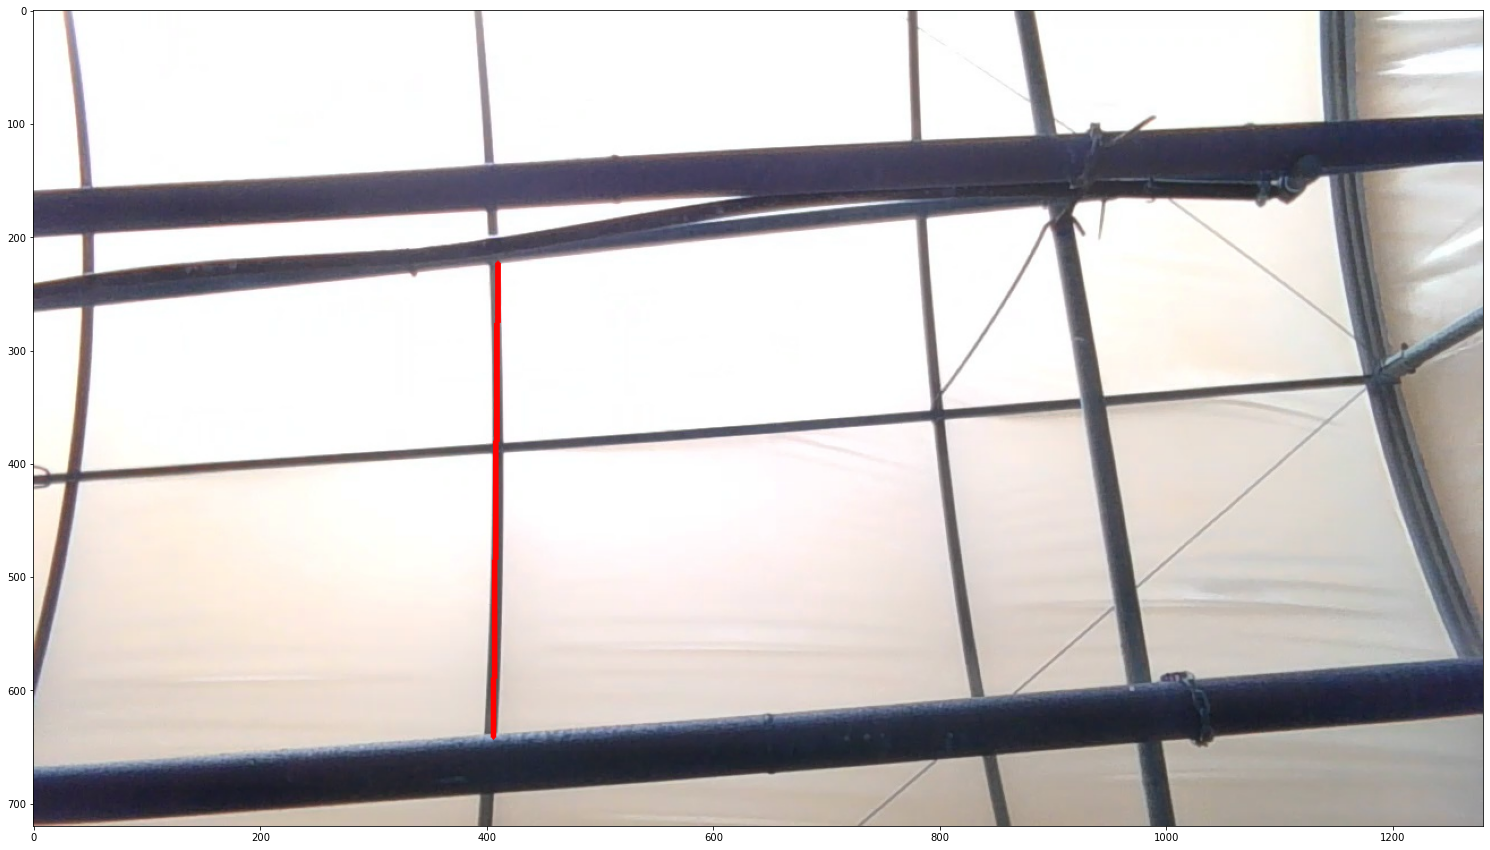

In [10]:
line_detection_object = BestLineDetection(90,5,80,0.25,20)
image = cv2.imread(imgfiles[3000])
print(image.shape)
start = time.time()
lines_info=line_detection_object.processImage(image)

#print(lines_info.shape)
prev_bestline,output_img,curr_lines =line_detection_object.bestline_picker(image)
end = time.time()

print("time elapsed = ", end - start)
print(output_img.shape)
canvas=np.zeros_like(output_img)

for i in lines_info:
    pt1 = (int(i[0]),int(i[1]))
    pt2 = (int(i[2]),int(i[3]))
    width = int(i[4])
    cv2.line(canvas, pt1, pt2, (255, 255, 255), 2)
    

plt.figure(figsize=(30,15)) 
plt.imshow(canvas)
plt.show()

plt.figure(figsize=(30,15)) 
plt.imshow(output_img)
plt.show()